In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
!pip install shap
import shap
import joblib

pd.set_option("display.max_columns", 200)

In [4]:
df = pd.read_csv("survey.csv")
df.head()


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,No,Yes,Yes,Not sure,No,Yes,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,No,No,Don't know,No,Don't know,Don't know,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,No,Yes,No,No,No,No,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,No,Yes,No,Yes,No,No,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,Yes,Yes,Yes,No,Don't know,Don't know,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [5]:
def clean_gender(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    if "f" in s: return "Female"
    if "m" in s: return "Male"
    return "Other"

In [6]:
df = df.copy()

if "Age" in df.columns:
    df = df[(df["Age"] >= 18) & (df["Age"] <= 80)]

df["Gender"] = df["Gender"].apply(clean_gender)

def to_yes_no(x):
    s = str(x).lower()
    if s.startswith("y"): return "Yes"
    if s.startswith("n"): return "No"
    return x

df["treatment"] = df["treatment"].apply(to_yes_no)


In [7]:
drop_cols = ["Timestamp", "comments", "state"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")


In [8]:
df = df[df["treatment"].isin(["Yes", "No"])]

df["target"] = (df["treatment"] == "Yes").astype(int)
df = df.drop(columns=["treatment"])



In [9]:
numeric_cols = df.select_dtypes(include=["int", "float"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "target"]

categorical_cols = [c for c in df.columns if c not in numeric_cols + ["target"]]

X = df[numeric_cols + categorical_cols]
y = df["target"]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)


In [11]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [12]:
X_train_enc = preprocess.fit_transform(X_train)
X_test_enc = preprocess.transform(X_test)


In [13]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_enc, y_train)

In [14]:
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_train_bal, y_train_bal)

logreg_proba = logreg.predict_proba(X_test_enc)[:, 1]
logreg_pred = (logreg_proba >= 0.5).astype(int)

print("LogReg Results:\n", classification_report(y_test, logreg_pred))
print("ROC-AUC:", roc_auc_score(y_test, logreg_proba))


LogReg Results:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83       155
           1       0.81      0.89      0.85       158

    accuracy                           0.84       313
   macro avg       0.84      0.84      0.84       313
weighted avg       0.84      0.84      0.84       313

ROC-AUC: 0.8973050224581461


In [15]:
rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X_train_bal, y_train_bal)

rf_proba = rf.predict_proba(X_test_enc)[:, 1]
rf_pred = (rf_proba >= 0.5).astype(int)

print("Random Forest Results:\n", classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_proba))


Random Forest Results:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81       155
           1       0.79      0.90      0.84       158

    accuracy                           0.83       313
   macro avg       0.83      0.83      0.83       313
weighted avg       0.83      0.83      0.83       313

ROC-AUC: 0.9076561861984482


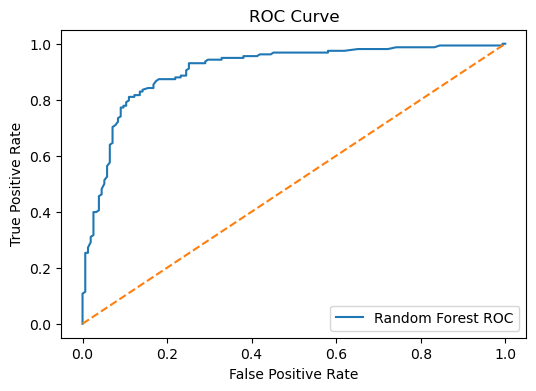

In [16]:
fpr, tpr, _ = roc_curve(y_test, rf_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Random Forest ROC")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


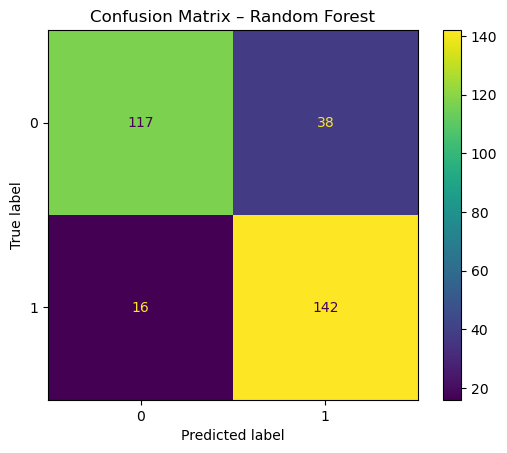

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred)
plt.title("Confusion Matrix – Random Forest")
plt.show()


In [20]:
# Get encoded feature names (numeric + one-hot encoded categorical)
ohe = preprocess.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(cat_feature_names)
print("Number of features:", len(feature_names))


Number of features: 111
